In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [34]:
df = pd.read_csv('../dataset/cleaned_NEM.csv')

In [38]:
df = df[['Close']]

df = df.reset_index(drop=True)

In [39]:
df

,Close
0,34.480000
1,34.380001
2,34.380001
3,33.970001
4,34.070000
...,...
1467,46.939999
1468,45.439999
1469,45.259998
1470,45.759998


# SPLITTING DATA(7-2-1)

In [61]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [62]:
# Training process

x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3302.363, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3304.210, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3304.212, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3300.579, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3306.211, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.108 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [64]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[52.43000031 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031
 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031
 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031
 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031
 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031 52.43000031]


In [65]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 12.79436926631494
Validation RMSE: 7.876473549378515
Testing MAE: 11.812211164727888
Validation MAE: 6.53405442385135
Testing MAPE: 0.3100363125757894
Validation MAPE: 0.15202559960543552


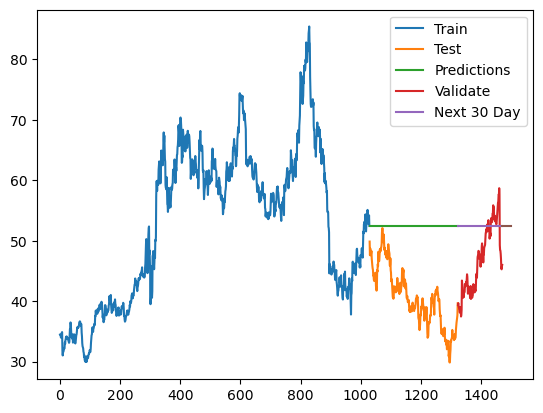

In [66]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

In [67]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1030
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1649.290
Date:                Fri, 08 Nov 2024   AIC                           3300.579
Time:                        09:07:29   BIC                           3305.516
Sample:                             0   HQIC                          3302.453
                               - 1030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.4445      0.035     40.997      0.000       1.375       1.514
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               883.42
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [68]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [69]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2839.034, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2840.625, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2840.623, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2837.529, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.498 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [70]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [71]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[59.70999908 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908
 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908
 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908
 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908
 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908 59.70999908]


In [72]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape)

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  18.01115994935315
Testing MAE:  17.112992271383224
Testing MAPE:  0.42635022555113855
Validation RMSE:  14.034343179827792
Validation MAE:  12.906755958581083
Validation MAPE:  0.29345243354799316


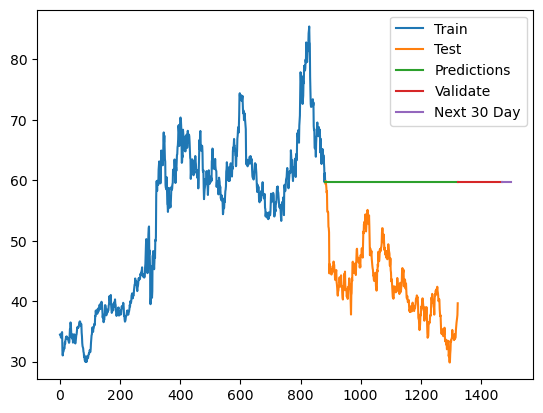

In [73]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [74]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [75]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2271.143, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2272.245, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2272.212, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2269.543, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2269.576, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.095 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [76]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [77]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[53.86999893 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893
 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893
 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893
 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893
 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893 53.86999893]


In [78]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape) 

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  11.876953086473884
Testing MAE:  10.320453107052154
Testing MAPE:  0.19730361531719437
Validation RMSE:  13.701534891884743
Validation MAE:  12.195185514169493
Validation MAPE:  0.3209324150052504


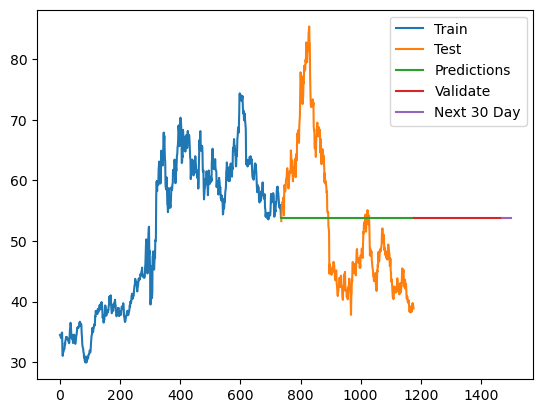

In [79]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# Comparison

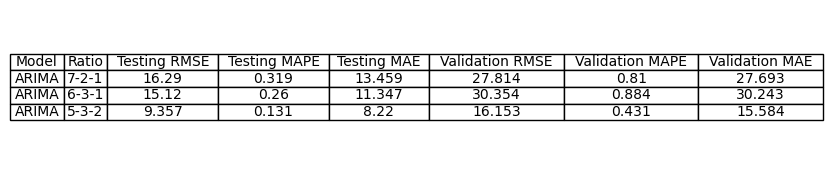

In [80]:
# Define the corrected data for the evaluation table
evaluation_data_corrected = {
    "Model": ["ARIMA", "ARIMA", "ARIMA"],
    "Ratio": ["7-2-1", "6-3-1", "5-3-2"],
    "Testing RMSE": [16.290, 15.120, 9.357],
    "Testing MAPE": [0.319, 0.260, 0.131],
    "Testing MAE": [13.459, 11.347, 8.220],
    "Validation RMSE": [27.814, 30.354, 16.153],    
    "Validation MAPE": [0.810, 0.884, 0.431],
    "Validation MAE": [27.693, 30.243, 15.584]
}

# Create a DataFrame from the corrected data
evaluation_df_corrected = pd.DataFrame(evaluation_data_corrected)

# Plot the corrected table using matplotlib
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust size as needed
ax.axis('off')  # Hide the axis

# Render the corrected table
table = ax.table(cellText=evaluation_df_corrected.values, colLabels=evaluation_df_corrected.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(evaluation_df_corrected.columns))))  # Adjust width of each column

# Save the corrected table as an image
corrected_table_image_path = '../ComparisonModel/ARIMA/NEM.png'
plt.savefig(corrected_table_image_path, bbox_inches='tight', dpi=300)
plt.show()
